In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

In [ ]:
# Define data directories and image dimensions
train_dir = "/content/drive/MyDrive/AI_CAPSTONE_PROJECT/Data/fsl_data(2)/train"
test_dir = "/content/drive/MyDrive/AI_CAPSTONE_PROJECT/Data/fsl_data(2)/test"
img_width, img_height = 28, 28

# Define data augmentation and preprocessing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=242,
    class_mode='binary'
)

# Load and preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=26,
    class_mode='binary'
)

# Create numpy arrays for training and testing data
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

Found 242 images belonging to 24 classes.
Found 26 images belonging to 24 classes.


((242, 28, 28, 3), (242,), (26, 28, 28, 3), (26,))

In [ ]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]
  
  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)
  
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [ ]:
make_paired_dataset(X_train, y_train)

(array([[[[[7.22006738e-01, 7.14163601e-01, 9.06320512e-01],
           [7.18620658e-01, 7.19621539e-01, 9.08830404e-01],
           [7.15234578e-01, 7.19156146e-01, 9.07391489e-01],
           ...,
           [7.23429859e-01, 7.15586722e-01, 9.07743633e-01],
           [7.22838759e-01, 7.14995623e-01, 9.07152474e-01],
           [7.17647076e-01, 7.09803939e-01, 9.01960850e-01]],
 
          [[7.19495595e-01, 7.07645655e-01, 9.04069722e-01],
           [7.19758451e-01, 7.11109698e-01, 9.06553566e-01],
           [7.17511475e-01, 7.12884188e-01, 9.06525850e-01],
           ...,
           [7.18889236e-01, 7.11046100e-01, 9.03202951e-01],
           [7.19094992e-01, 7.11251855e-01, 9.03408766e-01],
           [7.15831935e-01, 7.07988799e-01, 9.00145710e-01]],
 
          [[7.21872628e-01, 7.07114756e-01, 9.04254138e-01],
           [7.23576307e-01, 7.07890034e-01, 9.05493617e-01],
           [7.23037004e-01, 7.09206939e-01, 9.05882418e-01],
           ...,
           [7.24024951e-01, 7.1

In [ ]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train, y_train)

X_train_pairs.shape, y_train_pairs.shape

((58564, 2, 28, 28, 3), (58564,))

In [ ]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test, y_test)

X_test_pairs.shape, y_test_pairs.shape

((676, 2, 28, 28, 3), (676,))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.utils import to_categorical

img_A_inp = Input((28, 28,3), name='img_A_inp')
img_B_inp = Input((28, 28,3), name='img_B_inp')

def euclidean_distance(vectors):
    """
    Compute euclidean distance between two vectors
    """
    (featsA, featsB) = vectors
    sum_squared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((28, 28, 3)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

#concat = Concatenate()([feature_vector_A, feature_vector_B])
distance = Lambda(euclidean_distance)([feature_vector_A, feature_vector_B])

dense = Dense(1, activation='tanh')(distance)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 64)           1587648     ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['sequential_9[0][0]',     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], 
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=100,
          batch_size=32,
          callbacks=[es]
        )

Epoch 1/100
1831/1831 [==============================] - 90s 46ms/step - loss: 0.1896 - accuracy: 0.9583 - val_loss: 0.1054 - val_accuracy: 0.9527
Epoch 2/100
1831/1831 [==============================] - 84s 46ms/step - loss: 0.1518 - accuracy: 0.9583 - val_loss: 0.1023 - val_accuracy: 0.9527
Epoch 3/100
1831/1831 [==============================] - 83s 46ms/step - loss: 0.1356 - accuracy: 0.9583 - val_loss: 0.0843 - val_accuracy: 0.9527
Epoch 4/100
1831/1831 [==============================] - 84s 46ms/step - loss: 0.1263 - accuracy: 0.9583 - val_loss: 0.0841 - val_accuracy: 0.9911
Epoch 5/100
1831/1831 [==============================] - 84s 46ms/step - loss: 0.1192 - accuracy: 0.9583 - val_loss: 0.0877 - val_accuracy: 0.9882
Epoch 6/100
1831/1831 [==============================] - 84s 46ms/step - loss: 0.1119 - accuracy: 0.9586 - val_loss: 0.0741 - val_accuracy: 0.9852
Epoch 7/100
1831/1831 [==============================] - 84s 46ms/step - loss: 0.1033 - accuracy: 0.9602 - val_loss: 0

In [ ]:
img_A, img_B = X_test[5], X_train[5]
label_A, label_B = y_test[5], y_train[5]

label_A, label_B

(8.0, 8.0)

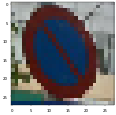

In [ ]:
plt.figure(dpi=28)
plt.imshow(img_A)

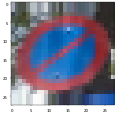

In [ ]:
plt.figure(dpi=28)
plt.imshow(img_B)

In [ ]:
result = model.predict([img_A.reshape((1, 28, 28, 3)), 
               img_B.reshape((1, 28, 28, 3))]).flatten()[0]
print('Similarity score:', result)
if result > 0.5:
  print("Same class")
else:
  print("Different classes")

1/1 [==============================] - 0s 21ms/step
Similarity score: 0.9880977
Same class


In [ ]:
model.save('/content/drive/MyDrive/AI_CAPSTONE_PROJECT/Code/saved_model/siamese_model')

In [ ]:
x=5
while(x!=2):
  print(x)
  x=x-1